# Percentile Analysis

In [1]:
import os
import sys

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

sys.path.append("..")
from constants import MIN_DAYSAHEAD, MAX_DAYSAHEAD, BIN_FREQ_PER_DAY
from summarize_percentiles import get_score

sns.set()

In [2]:
os.chdir("..")

# Load Data Frames from Disk

In [3]:
df = pd.DataFrame()
scores = pd.DataFrame()
# tag = "skew_gaussian/k200/delta_window8"
tag = "rfr"
real = 0

df_baseline = pd.DataFrame()
scores_baseline = pd.DataFrame()


for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
    # Load model dataframe
    df_cur = pd.read_csv(
        f"data/processed/{tag}/percentiles_daysahead{i}_R{real:03d}.csv"
    )
    df["TruePercentile"] = df_cur["TruePercentile"]
    df[f"{i} Days"] = df_cur["ObservedPercentile"]
    scores[f"{i} Days"] = [get_score(real, tag, i)]

    # Load baseline dataframe
    df_cur = pd.read_csv(f"data/processed/baseline/percentiles_daysahead{i}_R000.csv")
    df_baseline["TruePercentile"] = df_cur["TruePercentile"]
    df_baseline[f"{i} Days"] = df_cur["ObservedPercentile"]
    scores_baseline[f"{i} Days"] = [get_score(real, "baseline", i)]

In [4]:
df

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,5.124214,5.194967,5.415342,5.013406,4.946666,4.868002,5.033410
2,10,10.080319,10.545658,10.749673,10.001871,10.286320,10.179118,10.104290
3,15,15.347737,15.479008,15.554309,15.408119,15.700830,15.533920,15.537376
4,20,20.845526,20.786097,20.745311,20.340463,20.697399,20.845035,20.758134
5,25,26.337090,26.093185,25.761825,25.834009,25.712682,25.713038,25.641666
6,30,31.118859,31.232092,30.491681,30.872358,30.852723,30.911814,30.562668
7,35,35.906855,36.140526,35.495731,35.848351,36.055143,35.673719,35.658527
8,40,40.782019,40.762427,40.194429,40.886700,40.721103,40.498034,40.473365
9,45,45.787934,45.502678,45.223406,45.650683,45.505583,45.359795,45.381877


In [5]:
df_baseline

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,6.399078,6.440850,6.377570,6.126899,6.505372,6.521422,6.590794
2,10,12.387404,12.555306,12.355633,12.806163,12.857247,12.663946,13.354462
3,15,18.159545,18.640749,18.871214,19.013010,19.121409,19.054212,19.448246
4,20,23.852418,24.537608,24.275441,24.900065,25.341715,25.247741,25.786934
5,25,30.186640,30.151592,30.493208,31.121448,31.605877,31.302827,31.830296
6,30,35.605678,36.084717,36.231568,36.732321,37.460712,37.037307,37.945689
7,35,41.067954,41.372307,42.071621,42.263246,42.833126,42.443894,43.470431
8,40,46.278014,46.565605,47.650178,47.459844,48.475989,48.025357,48.642224
9,45,51.041291,51.410749,52.654899,52.496548,53.431767,52.972894,53.547504


# Model Results

In [6]:
pd.set_option("display.float_format", "{:.1f}".format)
df[df.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,26.3,26.1,25.8,25.8,25.7,25.7,25.6
10,50,50.6,50.2,50.3,50.5,50.4,50.0,50.0
15,75,75.1,74.1,74.3,74.9,74.3,75.0,72.8


In [7]:
df_err = pd.DataFrame(
    {
        f"{i} Days": df["TruePercentile"] - df[f"{i} Days"]
        for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)
    }
)
df_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.1,-0.2,-0.4,-0.0,0.1,0.1,-0.0
2,-0.1,-0.5,-0.7,-0.0,-0.3,-0.2,-0.1
3,-0.3,-0.5,-0.6,-0.4,-0.7,-0.5,-0.5
4,-0.8,-0.8,-0.7,-0.3,-0.7,-0.8,-0.8
5,-1.3,-1.1,-0.8,-0.8,-0.7,-0.7,-0.6
6,-1.1,-1.2,-0.5,-0.9,-0.9,-0.9,-0.6
7,-0.9,-1.1,-0.5,-0.8,-1.1,-0.7,-0.7
8,-0.8,-0.8,-0.2,-0.9,-0.7,-0.5,-0.5
9,-0.8,-0.5,-0.2,-0.7,-0.5,-0.4,-0.4


In [8]:
scores

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,66.1,82.4,60.5,50.0,67.6,42.3,104.0


# Baseline Results

In [9]:
df_baseline[df_baseline.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,30.2,30.2,30.5,31.1,31.6,31.3,31.8
10,50,55.7,56.1,57.2,57.1,58.3,57.5,58.0
15,75,77.2,77.9,78.0,77.9,78.2,78.3,77.2


In [10]:
scores_baseline

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,346.6,378.5,406.5,426.3,473.2,449.8,467.3


In [11]:
df_baseline_err = pd.DataFrame(
    {
        f"{i} Days": df_baseline["TruePercentile"] - df_baseline[f"{i} Days"]
        for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)
    }
)

In [12]:
df_baseline_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.4,-1.4,-1.4,-1.1,-1.5,-1.5,-1.6
2,-2.4,-2.6,-2.4,-2.8,-2.9,-2.7,-3.4
3,-3.2,-3.6,-3.9,-4.0,-4.1,-4.1,-4.4
4,-3.9,-4.5,-4.3,-4.9,-5.3,-5.2,-5.8
5,-5.2,-5.2,-5.5,-6.1,-6.6,-6.3,-6.8
6,-5.6,-6.1,-6.2,-6.7,-7.5,-7.0,-7.9
7,-6.1,-6.4,-7.1,-7.3,-7.8,-7.4,-8.5
8,-6.3,-6.6,-7.7,-7.5,-8.5,-8.0,-8.6
9,-6.0,-6.4,-7.7,-7.5,-8.4,-8.0,-8.5


# Comparison Plot 

In [13]:
def make_plot(df_plot, title, ax):
    for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
        ax.plot(df_plot.TruePercentile, df_plot[f"{i} Days"], "o-", label=f"{i} Days")
    ax.plot(
        df_plot.TruePercentile,
        df_plot.TruePercentile,
        color="red",
        label="Identity",
        linestyle="dashed",
    )
    ax.legend().set_title("Days Ahead")
    ax.set_xlabel("Target Percentile, $P_{target}$")
    ax.set_ylabel("Rate Observations Fell Within Bounds,\n$P_{obs}(P_{target})$")
    ax.set_xlim(0, 101)
    ax.set_ylim(0, 101)
    ax.set_yticklabels([str(p) + "%" for p in ax.get_xticks()])
    ax.set_xticklabels([str(p) + "%" for p in ax.get_xticks()])
    ax.set_title(title)

/tmp/ipykernel_3189658/3178010386.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(p) + "%" for p in ax.get_xticks()])
/tmp/ipykernel_3189658/3178010386.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(p) + "%" for p in ax.get_xticks()])


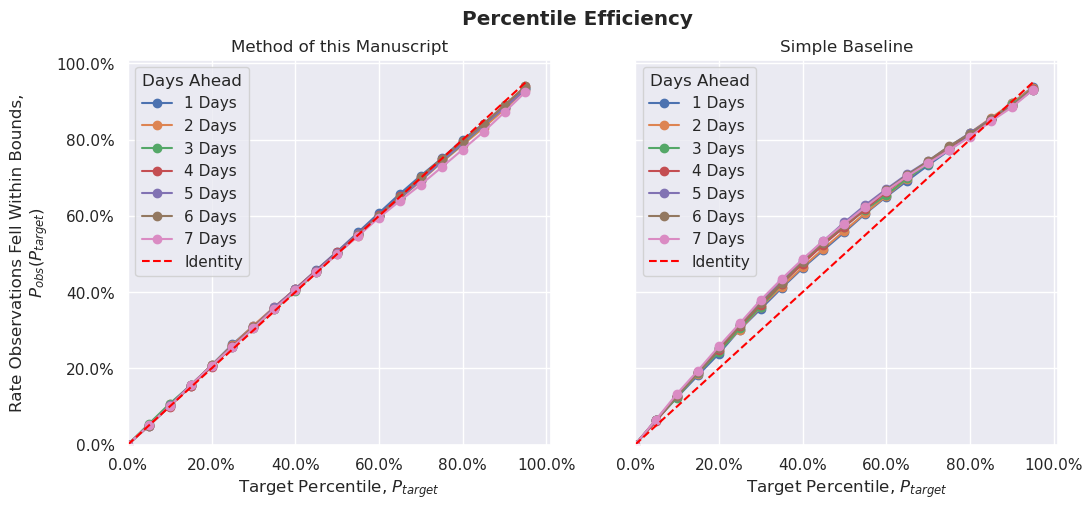

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

make_plot(df, "Method of this Manuscript", axes[0])
make_plot(df_baseline, "Simple Baseline", axes[1])
axes[1].set_ylabel("")
plt.suptitle("Percentile Efficiency", fontweight="bold")
plt.savefig("plots/percentile_efficiency.png", dpi=300)

In [15]:
np.abs(df_baseline_err) - np.abs(df_err)

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.3,1.2,1.0,1.1,1.5,1.4,1.6
2,2.3,2.0,1.6,2.8,2.6,2.5,3.3
3,2.8,3.2,3.3,3.6,3.4,3.5,3.9
4,3.0,3.8,3.5,4.6,4.6,4.4,5.0
5,3.8,4.1,4.7,5.3,5.9,5.6,6.2
6,4.5,4.9,5.7,5.9,6.6,6.1,7.4
7,5.2,5.2,6.6,6.4,6.8,6.8,7.8
8,5.5,5.8,7.5,6.6,7.8,7.5,8.2
9,5.3,5.9,7.4,6.8,7.9,7.6,8.2
